# **Lab 7.1 Data Augmentation with PyTorch**

In [252]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [261]:
def load_data(path=None, size=128, degrees=45, tx=0.1, ty=0.1, sx=0.8, sy=1.2, shear=45, center_crop=128):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((size, size)), 
        transforms.Pad(padding=size,padding_mode='reflect'), #ภาพผลลัพธ์ ต้องใหญ่กว่าภาพต้นฉบับ 2 เท่า เพื่อรองรับการ transform เช่น rotate
        transforms.ToTensor(),  # แปลงเป็น tensor
        transforms.RandomAffine(
            degrees=degrees, 
            translate=(tx, ty),
            scale=(sx, sy),
            shear=shear
        ),
        transforms.CenterCrop(center_crop)
    ])

    dataset = ImageFolder(root=path, transform=transform)
    # print("asdasdasdasd")
    # im, la = dataset[80]
    # print(im)
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True,pin_memory=True)
    
    # Print dataset information
    class_counts = {}
    for _, label in dataset.samples:
        class_name = dataset.classes[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1
    
    print("📃"+dataset.root.split("/")[1], "Dataset:")
    for class_name, count in class_counts.items():
        print(f"        Number of images in class {class_name}: {count}")
    print(f"        Number of samples: {len(dataset)}")
    
    return data_loader
    ### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


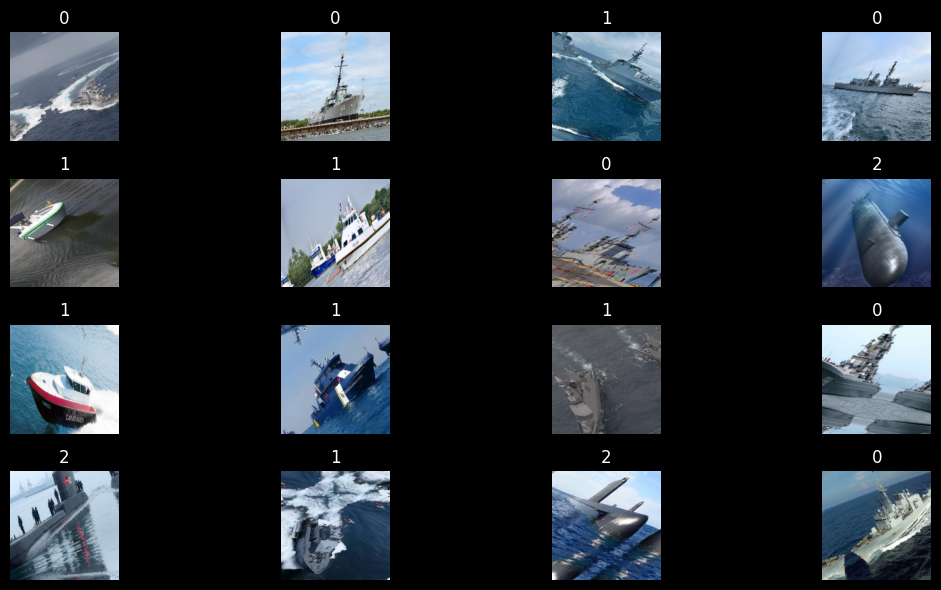

</details>

📃Train Dataset:
        Number of images in class battle ship: 44
        Number of images in class patrol ship: 35
        Number of images in class submarine: 35
        Number of samples: 114


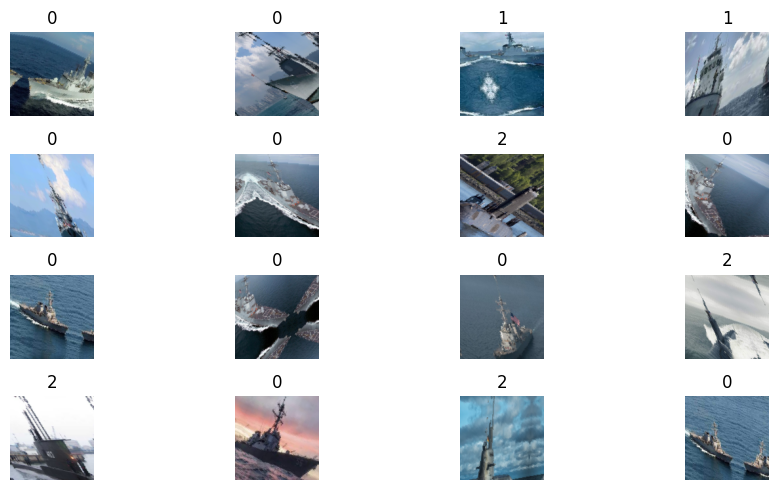

In [254]:

### START CODE HERE ###
def imshow_grid(images,labels):
    fig = plt.figure(figsize=(10, 5))
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        img = images[i]
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        a.axis("off")
        
        plt.title(str(labels[i].item()))
    
    plt.tight_layout()
    plt.show()

data_loader = load_data(path='Ship/Train')
images, labels = next(iter(data_loader))
imshow_grid(images,labels)


### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [264]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, image_paths,gauss_noise=False,gauss_blur=None,resize=128, center_crop=False):
        self.resize = resize
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur
        self.center_crop = center_crop
        self.dataset = ImageFolder(root=image_paths)

    def __len__(self):
        return len(self.dataset)
    
    def add_gaussian_noise(self, image):
        #สร้าง gaussian noise
        x, y, channel = image.shape
        mean = random.uniform(-50, 50)
        gaussian_noise = np.random.normal(loc=mean,scale=100,size=(x,y,channel)).astype(np.float32)
        #ภาพ ผสมกับ Gaussian Noise
        noisy_image = image + gaussian_noise
        return np.clip(noisy_image, 0, 255).astype(np.uint8)

    def do_gaussian_blur(self, image):
        kernel_size = random.randrange(3, 12, 2)
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0) #ภาพ,Kernel Size, Standard Deviation
    
    def do_center_crop(self, image, desire_h=128, desire_w=128):
        height,width, _ = image.shape
        if width <= height: #กรณี width สั้น ให้ resize โดยยึด width 
            #ปรับ width เทียบเท่าแล้ว เหลือ Height ที่ยังเกิน
            #เพื่อให้สัดส่วนคงเดิม ไม่ถูกบีบ ให้หาอัตราส่วนภาพ
            img_ratio = height / width
            image = cv2.resize(image, (self.resize, int(self.resize*img_ratio))) #image , (width, height) ที่จะไป
            #พอ resize แล้ว จะได้ width height ตัวใหม่ 
            new_resize_h, new_resize_w, _ = image.shape
            crop_img = image[new_resize_h//2 - self.resize//2: new_resize_h//2 + self.resize//2, 0:self.resize]
        else:
            #ปรับ Height เทียบเท่าแล้ว เหลือ width ที่ยังเกิน
            img_ratio = width / height
            image = cv2.resize(image, (int(self.resize*img_ratio), self.resize))
            new_resize_h, new_resize_w, _ = image.shape
            crop_img = image[0:self.resize, new_resize_w//2 - self.resize//2: new_resize_w//2 + self.resize//2]
        return crop_img
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        # Convert PIL Image to NumPy array
        image = np.array(image)
        # print(image.shape)
        if image.ndim == 2: #ถ้าเป็น Gray --> บังคับเป็น RGB Format
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        # Perform augmentations
        if self.center_crop:
            image = self.do_center_crop(image, desire_h=self.resize, desire_w=self.resize)
        else:
            image = cv2.resize(image, (self.resize, self.resize))
        if self.gauss_noise:
            image = self.add_gaussian_noise(image)
        if self.gauss_blur:
            image = self.do_gaussian_blur(image)
        # Convert NumPy array to PyTorch tensor
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        return image,label
    
### END CODE HERE ###

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

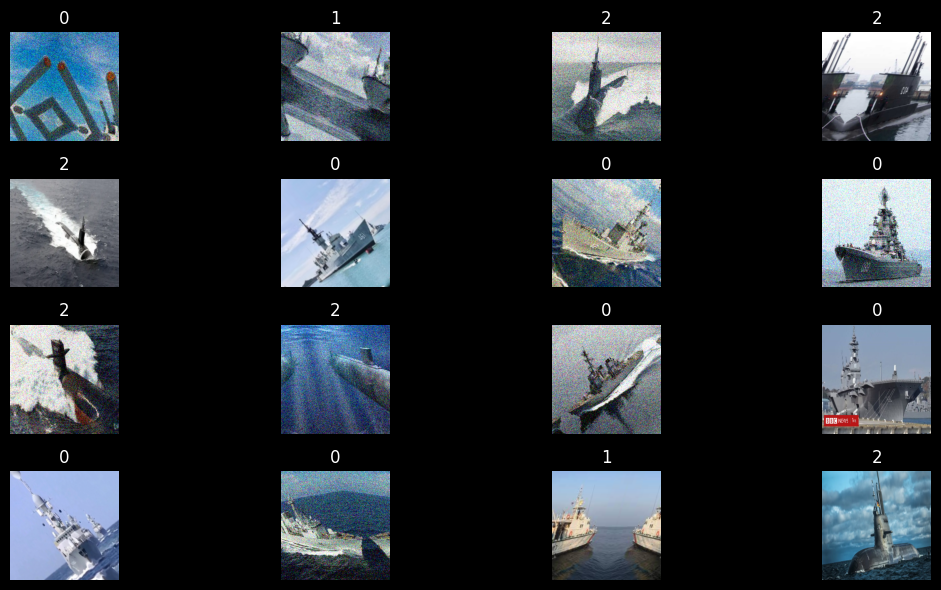

</details>

torch.Size([16, 3, 128, 128])


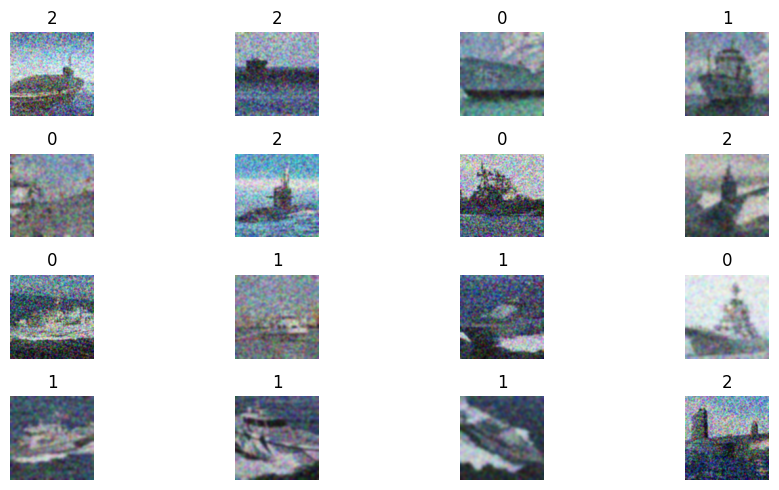

In [265]:
### START CODE HERE ###
data_dir = "Ship/Train"
dataset = CustomImageDataset(image_paths=data_dir,
                             gauss_noise=True,
                             gauss_blur=True,
                             resize=128,
                             center_crop=True)
dataloader = DataLoader(dataset,batch_size=16,shuffle=True,pin_memory=True)
images_cus, labels_cus = next(iter(dataloader))
print(images_cus.shape)
print("============")
imshow_grid(images_cus,labels_cus)

### END CODE HERE ###

---
# Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?